In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# Global variables
data_dir = '/kaggle/input/killer-shrimp-invasion/'
RANDOM_STATE = 0

In [ ]:
# Import data
train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')

# Split data into different variables
Y_train = train['Presence']
ID_train = train['pointid']
X_train = train.drop(['Presence', 'pointid'], axis = 1)
ID_test = test['pointid']
X_test = test.drop(['pointid'], axis = 1)

In [ ]:
# Fill in NaN values using sklearn imputer
imputer = IterativeImputer(max_iter = 10, random_state = RANDOM_STATE)
imputer.fit(X_train)
column_names = list(X_train.columns)
X_train = pd.DataFrame(imputer.transform(X_train), columns = column_names)
X_test = pd.DataFrame(imputer.transform(X_test), columns = column_names)

# Feature Engineering
We only have five features in the training data (temperature, salinity, depth, exposure, and substrate).  We will use feature engineering to create more features. Those used in this notebook are:
 - Ocean Density
 - EUNIS Exposure Classifications (for which we actually create nine features)
 - Temperature Equation
 - Outlier (Bounded-Box)

Each is dealt with in a separate cell.

In [ ]:
# If you notice any errors with this function please let me know as it was transcribed by hand from the linked source
def ocean_density(temp, salin, depth):
    # Get approximate pressure at given depth
    pressure_approx = 1 + (depth / 10)

    # Standard Mean Ocean Water density
    smow = 999.842594 + (6.793953e-2 * temp) - (9.095290e-3 * (temp ** 2)) + (1.001685e-4 * (temp ** 3)) - (1.120083e-6 * (temp ** 4)) + (6.536332e-9 * (temp ** 5))

    # Sea water density at normal atmospheric pressure
    B = 0.82449 - (4.0899e-3 * temp) + (7.6438e-5 * (temp ** 2)) - (8.2467e-7 * (temp ** 3)) + (5.3875e-9 * (temp ** 4))
    C = -5.7246e-3 + (1.0227e-4 * temp) + (-1.6546e-6 * (temp ** 2))
    D = 4.8314e-4
    density_normal = smow + (B * salin) + (C * (salin ** 1.5)) + (D * (salin ** 2))

    # Determination of compression module at pressure 0
    Kw = 19652.21 + (148.4206 * temp) + (-2.327105 * (temp ** 2)) + (1.360477e-2 * (temp ** 3)) + (-5.155288e-5 * (temp ** 4))
    F = 54.6746 + (-0.603459 * temp) + (1.099870e-2 * (temp ** 2)) + (-6.167e-5 * (temp ** 3))
    G = 7.9440e-2 + (1.6483e-2 * temp) + (-5.3009e-4 * (temp ** 2))
    K_0 = Kw + (F * salin) + (G * (salin ** 1.5))

    # Determination of final compressibility module
    Aw = 3.23990 + (1.43713e-3 * temp) + (1.16092e-4 * (temp ** 2)) + (-5.77905e-7 * (temp ** 3))
    A1 = Aw + ((2.28380e-3 + (-1.09810e-5 * temp) + (-1.60780e-6 * (temp ** 2))) * salin) + (1.91075e-4 * (salin ** 1.5))
    Bw = 8.50935e-5 + (-6.12293e-6 * temp) + (5.27870e-8 * (temp ** 2))
    B2 = Bw + (-9.9348e-7 + (2.0816e-8 * temp) + (9.1697e-10 * (temp ** 2))) * salin
    K = K_0 + (A1 * pressure_approx) + (B2 * (pressure_approx ** 2))

    return (density_normal / (1 - (pressure_approx / K))) - 1000

In [ ]:
X_train['Density'] = X_train.apply(lambda x: ocean_density(x['Temperature_today'], x['Salinity_today'], x['Depth']), axis = 1)
X_test['Density'] = X_test.apply(lambda x: ocean_density(x['Temperature_today'], x['Salinity_today'], x['Depth']), axis = 1)

## EUNIS Exposure Classifications

EUNIS Exposure Classifications are categorical features for the exposure feature.

| EUNIS Subclass | SWM Minimum | SWM Maxium |
| --- | --- | --- |
| Extremely Exposed | 2000000 | 5000000 |
| Very Exposed | 1000000 | 2000000 |
| Exposed | 500000 | 1000000 |
| Moderately Exposed | 100000 | 500000 |
| Sheltered | 10000 | 100000 |
| Very Sheltered | 4000 | 10000 |
| Extremely Sheltered | 1200 | 4000 |
| Ultra Sheltered | 1 | 1200 |

In the report these subclasses are grouped into three classes of energy-level; exposed (extremely exposed, very exposed, exposed), moderately exposed (moderately exposed), and sheltered (sheltered, very sheltered, extremely sheltered, ultra sheltered). We will not extract these energy classes as feature but we will take a subset of the exposed class in a feature that we call 'EUNIS Min Very Exposed'.

In [ ]:
def eunis_classification(exposure):
    if exposure <= 1200:
        return 'Ultra Sheltered'
    elif exposure <= 4000:
        return 'Extremely Sheltered'
    elif exposure <= 10000:
        return 'Very Sheltered'
    elif exposure <= 100000:
        return 'Sheltered'
    elif exposure <= 500000:
        return 'Moderately Exposed'
    elif exposure <= 1000000:
        return 'Exposed'
    elif exposure <= 2000000:
        return 'Very Exposed'
    else:
        return 'Extremely Exposed'

In [ ]:
for classifi in ['Ultra Sheltered', 'Extremely Sheltered', 'Very Sheltered', 'Sheltered', 'Moderately Exposed', 'Exposed', 'Very Exposed']:
    X_train['EUNIS ' + classifi] = X_train['Exposure'].apply(lambda x: 1 if eunis_classification(x) == classifi else 0)
    X_test['EUNIS ' + classifi] = X_test['Exposure'].apply(lambda x: 1 if eunis_classification(x) == classifi else 0)

X_train['EUNIS Min Very Exposed'] = X_train['Exposure'].apply(lambda x: 1 if eunis_classification(x) == 'Extremely Exposed' or eunis_classification(x) == 'Very Exposed' else 0)
X_test['EUNIS Min Very Exposed'] = X_test['Exposure'].apply(lambda x: 1 if eunis_classification(x) == 'Extremely Exposed' or eunis_classification(x) == 'Very Exposed' else 0)

## Temperature-Only Model Equation
A full explanation of this feature can be found. In the notebook, a logistic regression model is fitted to the training data using only the temperature feature. The resulting equation gives a decent model for the problem, but can also be used as an additional feature. Similar equations can be calculated for other features such as depth or salinity but the cross validation score is not as high as that for temperature. The cross validation score achieved for the temperature equation was approximately 0.87. The linked notebook shows that a salinity model only had an approximate score of 0.58. The temperature equation is given below:

$$ p(Shrimp) = \frac{1}{1 + e^{-f(t)}}$$  

$$ f(t) = -10.52910058 + 2.21529641*t - 0.57623745*t^2 - 2.06832485*t^3\\ + 0.30713969*t^4 - 2.21781761*t^5 - 1.85363275*t^6$$

In [ ]:
def temperature_equation(t):
    coefs = [-10.52910058, 2.21529641, -0.57623745, -2.06832485, 0.30713969, -2.21781761, -1.85363275]
    temps = [1, t, t**2, t**3, t**4, t**5, t**6]
    summed = np.dot(coefs, temps)
    return 1 / (1 + np.exp(summed))

In [ ]:
X_train['Temperature Model'] = X_train['Temperature_today'].apply(lambda x: temperature_equation(x))
X_test['Temperature Model'] = X_test['Temperature_today'].apply(lambda x: temperature_equation(x))

## Outlier (Bounded Box) Feature
Information on the habitat of Killer Shrimp is given. Notably they:
 - tolerate salinity up to 20ppt (12ppt is optimal)
 - tolerate temperatures between 0 and 35 degress Celsius (5-15 degrees is optimum)
 - are thought to occupy every substratum except for sand
 - are present in areas of low current velocity

Hard-coding these conditions into the model poses difficulties, particularly with the substratum (training data suggests they are found in sand substratum). Instead, we will create a bounded box around the data using our training data. Since it is possible that unseen data (such as our test data) could fall outside of this bounded box, we also introduce a ratio that expands the bounding box slightly. The ratio of 0.82 in this notebook was chosen experimentally.

Experimentally, this outlier feature had greater use in models that used fewer other features. As the number of features increased, the model was better able to remove outliers without the explicit need for an outlier feature.

In [ ]:
# Wrapper to remove outliers
class OutlierFeature():
    def __init__(self, ratio, outlier_features):
        self.ratio = ratio
        self.outlier_features = outlier_features

    def exclude_outliers(self, row):
        lower_multiplier = self.ratio
        upper_multiplier = 1 / self.ratio
        conditions = []
        for feature, cmin, cmax in self.outlier_conditions:
            conditions.append(row[feature] > cmin)
            conditions.append(row[feature] < cmax)
        return 1 if sum(conditions) == len(conditions) else 0

    def fit(self, x, y):
        self.outlier_conditions = []
        for feature in self.outlier_features:
            fmin = x[y == 1][feature].min()
            fmax = x[y == 1][feature].max()
            lower_multiplier = self.ratio
            upper_multiplier = 1 / self.ratio

            cmin = fmin * lower_multiplier if fmin > 0 else fmin * upper_multiplier
            cmax = fmax * upper_multiplier if fmax > 0 else fmax * lower_multiplier
            self.outlier_conditions.append((feature, cmin, cmax))

    def transform(self, x):
        outliers = x.apply(lambda x: self.exclude_outliers(x), axis = 1)
        return outliers

In [ ]:
outlier_finder = OutlierFeature(0.82, ['Temperature_today', 'Salinity_today', 'Exposure', 'Depth'])
outlier_finder.fit(X_train, Y_train)
X_train['Outlier'] = outlier_finder.transform(X_train)
X_test['Outlier'] = outlier_finder.transform(X_test)

# Models
Firstly we will define a function that allows us the perform stratified cross validation. We will be using five folds. Setting verbose to True will output the AUROC score for each fold as well as the final average. The final average is also returned from the function.

In [ ]:
# K-Fold Cross Validation
def five_fold_cv(model, X_train, Y_train, verbose = True):
    skf = StratifiedKFold(n_splits = 5)
    fold = 1
    scores = []

    for train_index, test_index in skf.split(X_train, Y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_fold, Y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

        model.fit(X_train_fold, Y_train_fold)

        preds = model.predict_proba(X_test_fold)
        preds = [x[1] for x in preds]

        score = roc_auc_score(Y_test_fold, preds)
        scores.append(score)
        if verbose:
            print('Fold', fold, '     ', score)
        fold += 1

    avg = np.mean(scores)
    if verbose:
        print()
        print('Average:', avg)
    return avg

We will also define a list of features that will be used in the model.

In [ ]:
features = ['Temperature_today', 'Salinity_today', 'Depth', 'EUNIS Ultra Sheltered', 'EUNIS Extremely Sheltered', 'EUNIS Very Sheltered', 'EUNIS Sheltered', 'EUNIS Moderately Exposed', 'EUNIS Exposed', 'EUNIS Very Exposed', 'Substrate', 'Outlier', 'Temperature Model', 'Density', 'EUNIS Min Very Exposed']

Now we will create an XGB model and check its performance by doing cross validation.

In [ ]:
model = XGBClassifier(random_state = RANDOM_STATE, eval_metric = 'auc', objective = 'binary:logistic',
                          learning_rate = 0.3, max_depth = 5, subsample = 1, reg_lambda = 0.5)

score = five_fold_cv(model, X_train[features], Y_train, verbose=True)

Fold 1       0.9996484189802342
Fold 2       0.9977843636412104
Fold 3       0.9989777208258204
Fold 4       0.9991787874691307
Fold 5       0.9989130765920663

Average: 0.9989004735016923


# Predictions
With our model created we can now make predictions. Our predictions will be outputted to _preds.csv_.

In [ ]:
preds = pd.DataFrame(ID_test, columns=['pointid'])

model.fit(X_train[features], Y_train)
preds['Presence'] = model.predict_proba(X_test[features])[:,1]

preds[['pointid', 'Presence']].to_csv('preds.csv', index=False)

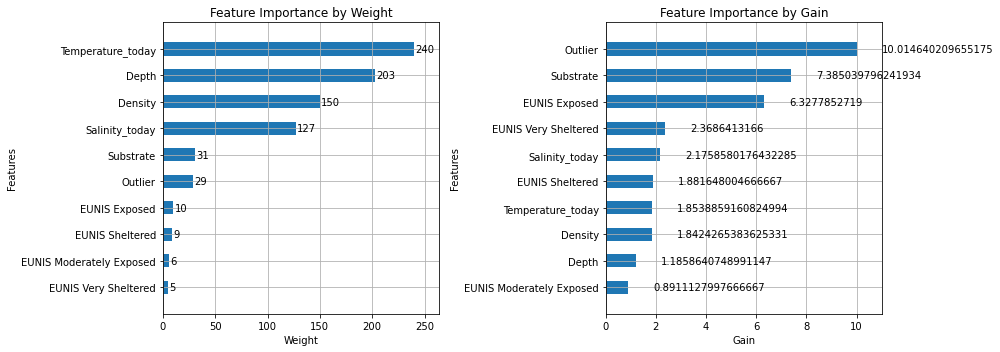

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_importance(model, importance_type='weight', height=0.5, xlabel='Weight', title='Feature Importance by Weight', ax=ax1)
plot_importance(model, importance_type='gain', height=0.5, xlabel='Gain', title='Feature Importance by Gain', ax=ax2)
plt.tight_layout()
plt.show()